In [3]:
library(tidyverse)
library(lubridate)
library(cowplot)
library(yardstick)
library(DBI)
library(gnm)
library(ggbeeswarm)
library(glmnet)
library(pROC)
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 400)

In [4]:
con1 <- DBI::dbConnect(
    RMySQL::MySQL(), 
    host = "localhost",
    user = "uog2000",
    port = 3307,
    dbname = "user_uog2000",
    password = read_file('/home/uog2000/mimir_setup/password.txt') %>% str_replace('\n', '')
)

## Data Collection and Preprocessing

In [ ]:
sccs_dat <- con1 %>% tbl('ade_sccs_wcounts') %>% as_tibble() %>%
            unite(col = "birth_date", year_of_birth, month_of_birth, day_of_birth,  sep = '-') %>%
            mutate(birth_date = ymd(birth_date),
                   start = as.Date(start, format = '%Y-%m-%d'),
                   end = as.Date(end, format = '%Y-%m-%d'))

In [7]:
sccs_dat <- sccs_dat %>%
      group_by(person_id, drug_concept_id) %>%
      filter(max(risk) > 0, sum(!risk) >= sum(risk)) %>% ungroup() %>%
      group_by(drug_concept_id) %>%
      filter(n_distinct(person_id) >= 10) %>% ungroup() %>%
      mutate(min_age = time_length((start - birth_date), 'years') %>% round(digits = 2),
             max_age = time_length((end - birth_date), 'years') %>% round(digits = 2),
             mid_age = (max_age + min_age)/2 %>% round(digits = 2))

In [ ]:
summary(sccs_dat)

### Data Cleaning

In [9]:
# replace NAs with 0
# remove unreasonable ages
age_99 = quantile(sccs_dat$min_age, probs = 0.99)
sccs_dat <- sccs_dat %>%
    mutate_at(vars( starts_with("num_") ), function(x) if_else( is.na(x), 0, x) ) %>%
    group_by(person_id) %>%
    filter(max(min_age) <= age_99,
           min(min_age) >= 18) %>% ungroup()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


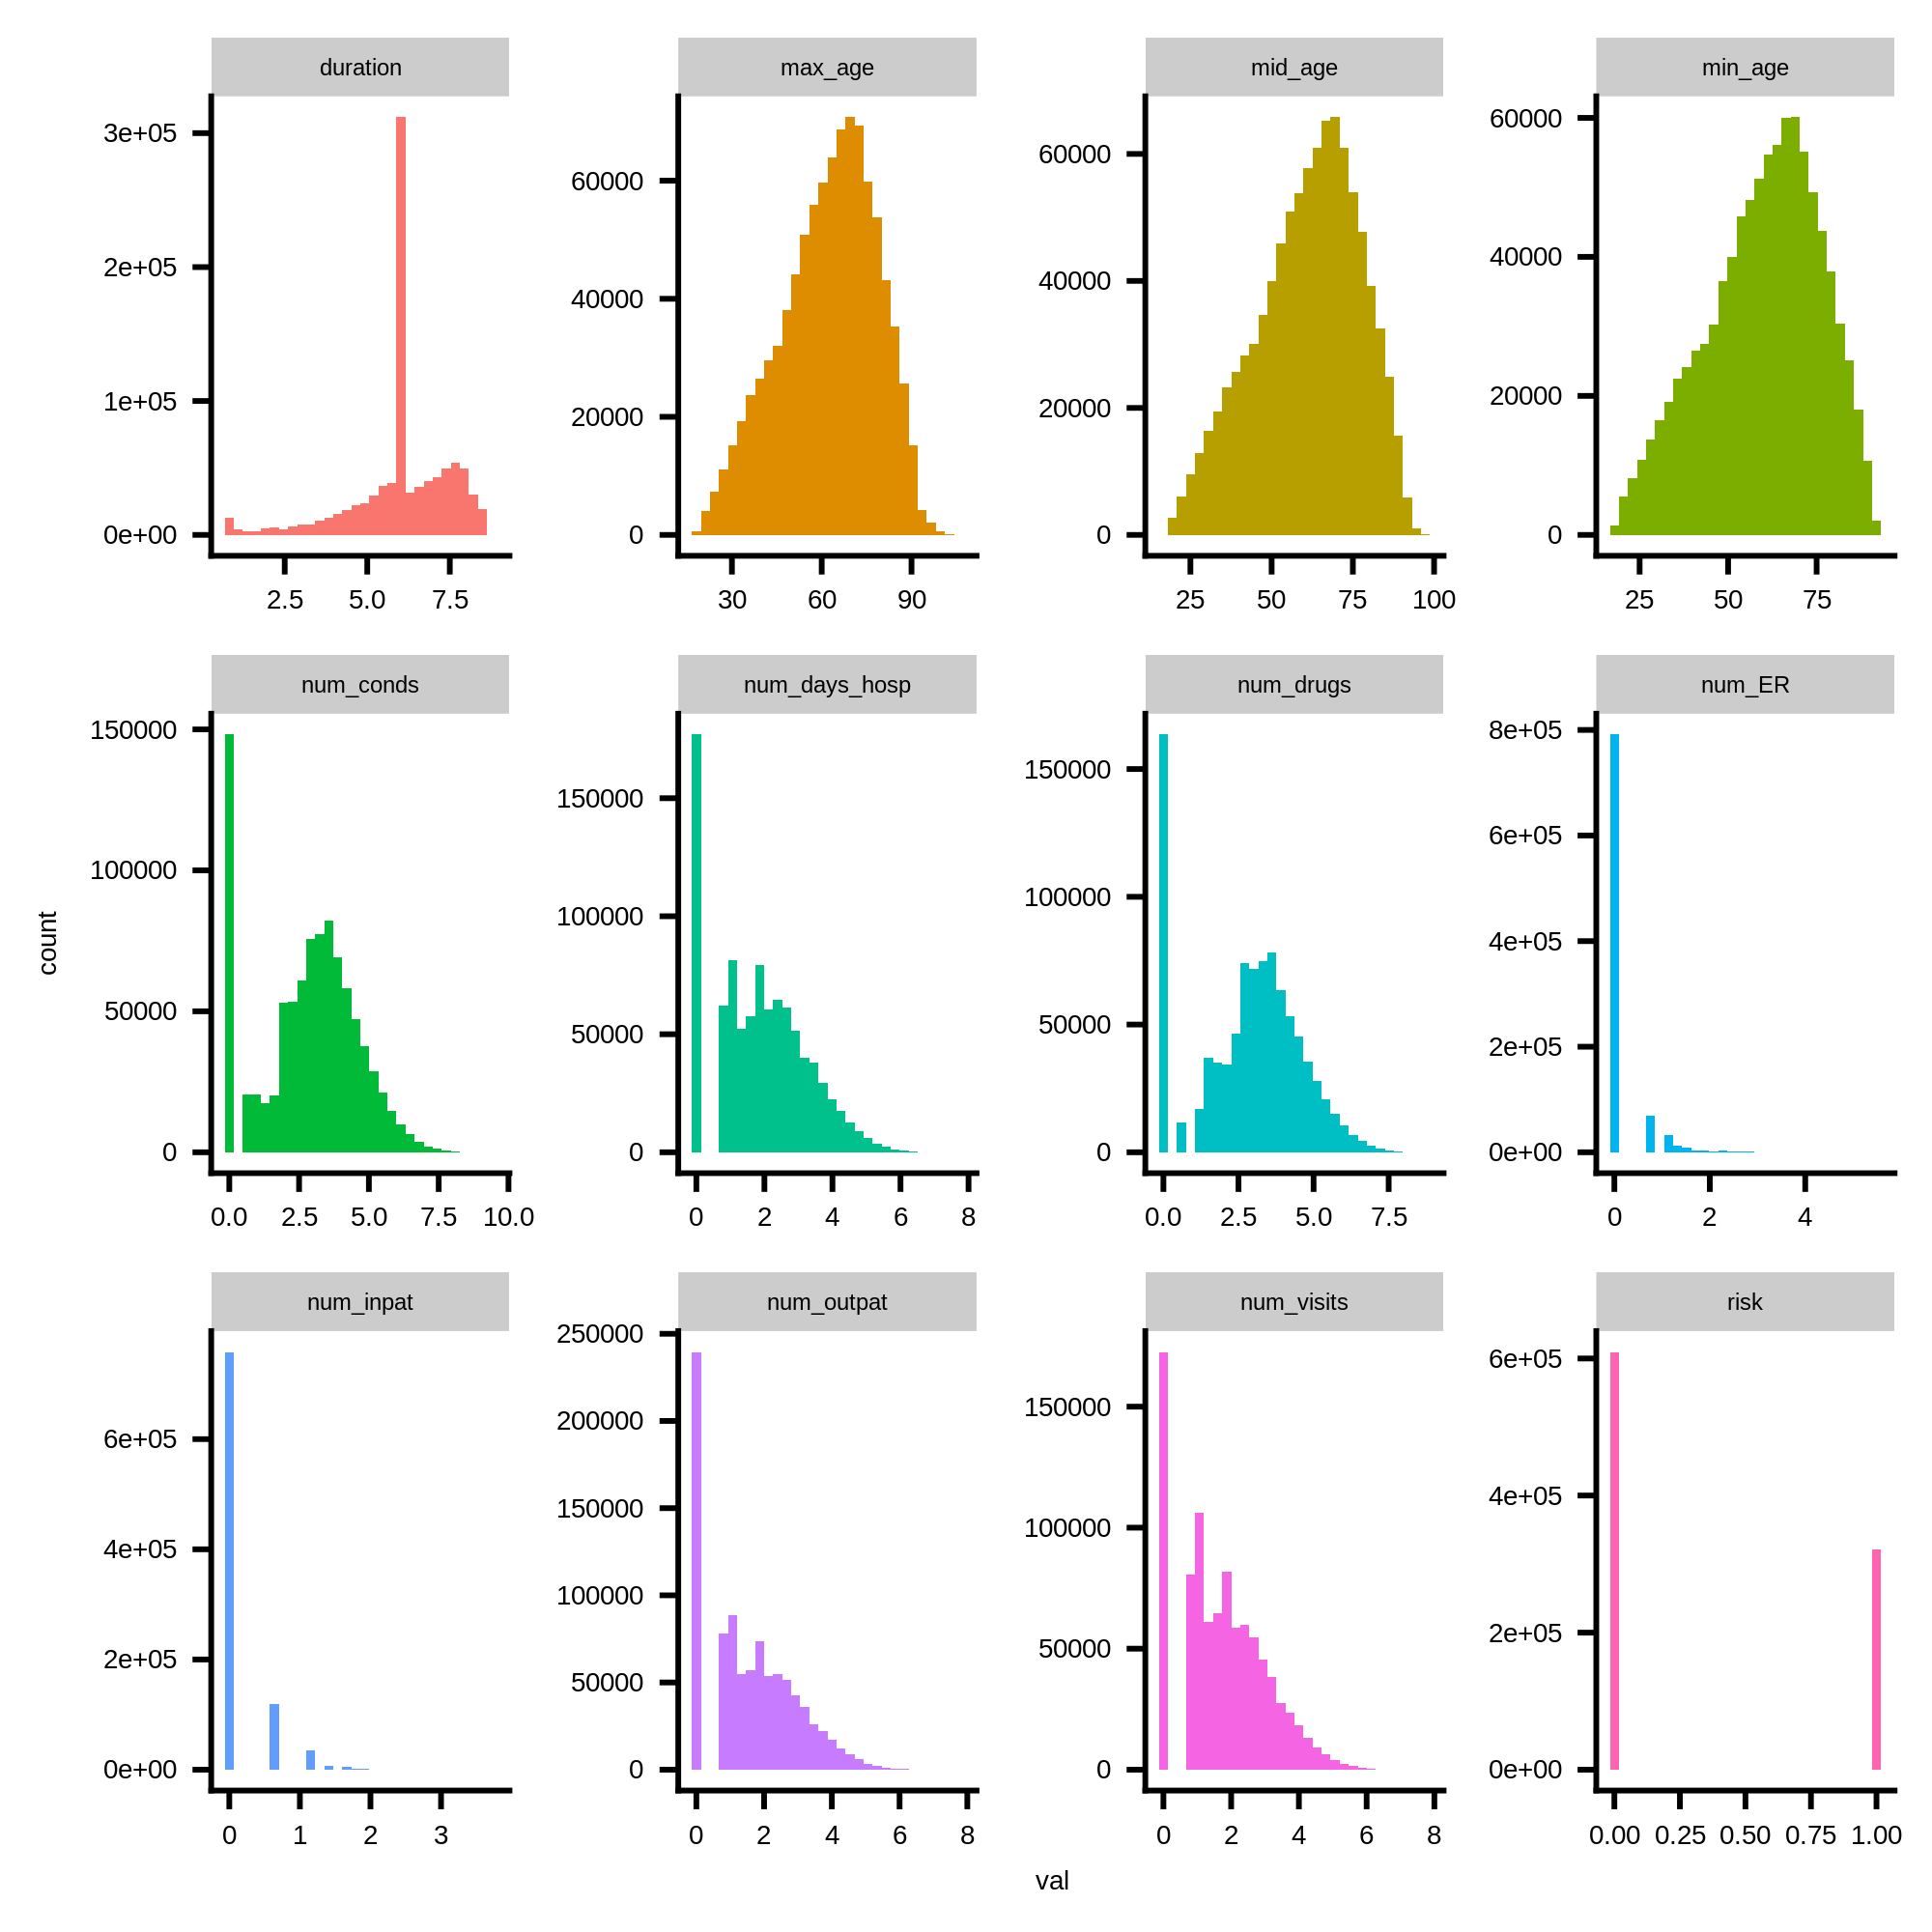

In [10]:
sccs_dat %>%
    select(drug_concept_id, duration, risk, starts_with('num'), ends_with('age')) %>%
    mutate_at(vars(duration, starts_with('num')), function(x) log(x + 1)) %>%
    pivot_longer(duration:mid_age, names_to = 'var', values_to = 'val') %>%
ggplot(mapping = aes(x = val, fill = var)) +
    geom_histogram() +
    facet_wrap(~var, scales = 'free') + 
    theme_cowplot() + 
    theme(legend.position = 'none',
          axis.text = element_text(size = 5),
          text = element_text(size = 5))

## Adding Propensity Scores

Add `utilization score` (the fitted value) using elastic net and log transformed count data (number of drugs, condition, etc.)

In [ ]:
add_fitted_vals <- function(data, predictors, predicting, alpha = 0.5, log_norm = FALSE) {
    # get the fitted values for the elastic net model
    if (log_norm){
        data <- data %>% 
            mutate_at(vars(starts_with('num')), `.funs` = function(x) log(x + 1))
    }
    x = as.matrix(data[,predictors])
    y = as.matrix(data[,predicting])
    
    fit = glmnet(x = x, y = y, 
                                alpha = alpha, family = "binomial")
    out = predict(fit, newx = x, type = 'response')[,paste0('s', fit$dim[2] - 1)]
    return(out)
}

In [ ]:
# add fitted values
set.seed(100)
sccs_ps <- sccs_dat %>%
    filter(!is.na(birth_date)) %>%
    nest(data = c(-drug_concept_id)) %>%
    mutate(
        ps_score = data %>%
                        map(~add_fitted_vals(., c('duration', 'num_conds', 'num_drugs', 'num_visits', 'num_inpat',
                                          'num_outpat', 'num_ER', 'num_days_hosp', 'min_age', 'max_age', 'mid_age'),
                                  "risk", log_norm = TRUE))
        ) %>%
    unnest(cols = c(data, ps_score))

In [ ]:
dbWriteTable(con1,
             "sccs_psm_score",
             sccs_ps %>% select(person_id, drug_concept_id, start, end, duration, risk,
                                age_at_start=min_age,
                                propensity_score = ps_score))

## Supplementary Table 2: Poisson Regression Coefficients

**Supplementary Table 2** Results from Poisson regression models.

In [12]:
set.seed(100)
pois_gnm <- sccs_dat %>%  
    group_by(drug_concept_id, risk) %>%
    pivot_longer(starts_with('num'), names_to = 'var', values_to = 'val') %>%
    nest(data = -c(drug_concept_id, var)) %>%
        mutate(res =  data %>% map(~gnm(formula=val ~ risk , offset = log(duration),
                            family = 'poisson', data = .)) %>%
                   map(broom::tidy)) %>%
    unnest(res) %>% select(-data)

In [96]:
pois_gnm %>% 
    filter(term == 'risk') %>%
    mutate(var_names = case_when(var == 'num_days_hosp' ~ 'Days in Hospital',
                                 var == 'num_conds' ~ 'Conditions',
                                 var == 'num_drugs' ~ 'Drugs',
                                 var == 'num_visits' ~ 'Visits',
                                 var == 'num_outpat' ~ 'Outpatient visits',
                                 var == 'num_ER' ~ 'ER visits',
                                 var == 'num_inpat' ~ 'Inpatient visits'),
          significant = factor(ifelse(p.value <=0.05, 'Significant', 'N.S.'))) %>%
select(var_names, drug_concept_id, estimate, std.error, p.value, significant) %>%
arrange(var_names, drug_concept_id) %>%
rename('Outcome Variable'=var_names, 'Drug concept ID'=drug_concept_id) %>%
write_csv('supplementary_table_2.csv')

In [89]:
pois_gnm %>% filter(term == 'risk') %>%
    group_by(p.value <= 0.05) %>% 
    summarise(n = n(),
              perc = n/nrow(.)*100)

p.value <= 0.05,n,perc
<lgl>,<int>,<dbl>
FALSE,59,5.50887
TRUE,1012,94.49113


## Figure 1: Difference between Risk and Baseline periods

**Figure 1** Figure 21: Coefficients from Poisson regression models. The x-axis shows the outcome variables of the univariate Poisson regression model using binary risk/baseline period as the predictor. We performed this regression for each drug in the reference set of ADEs. Each point on the graph corresponds to an individual drug. Gray dots indicate coefficients that did not meet the threshold of statistical significance (p-value <= 0.05). The ‘risk’ period was significantly associated with increases in the number of conditions, days in the hospital, concomitant drugs, ER visits, inpatient visits, outpatient visits, and total visits for most of the drugs when using EHR data.

Warning message:
“Removed 7 rows containing missing values (`position_beeswarm()`).”
Warning message:
“Removed 7 rows containing missing values (`position_beeswarm()`).”


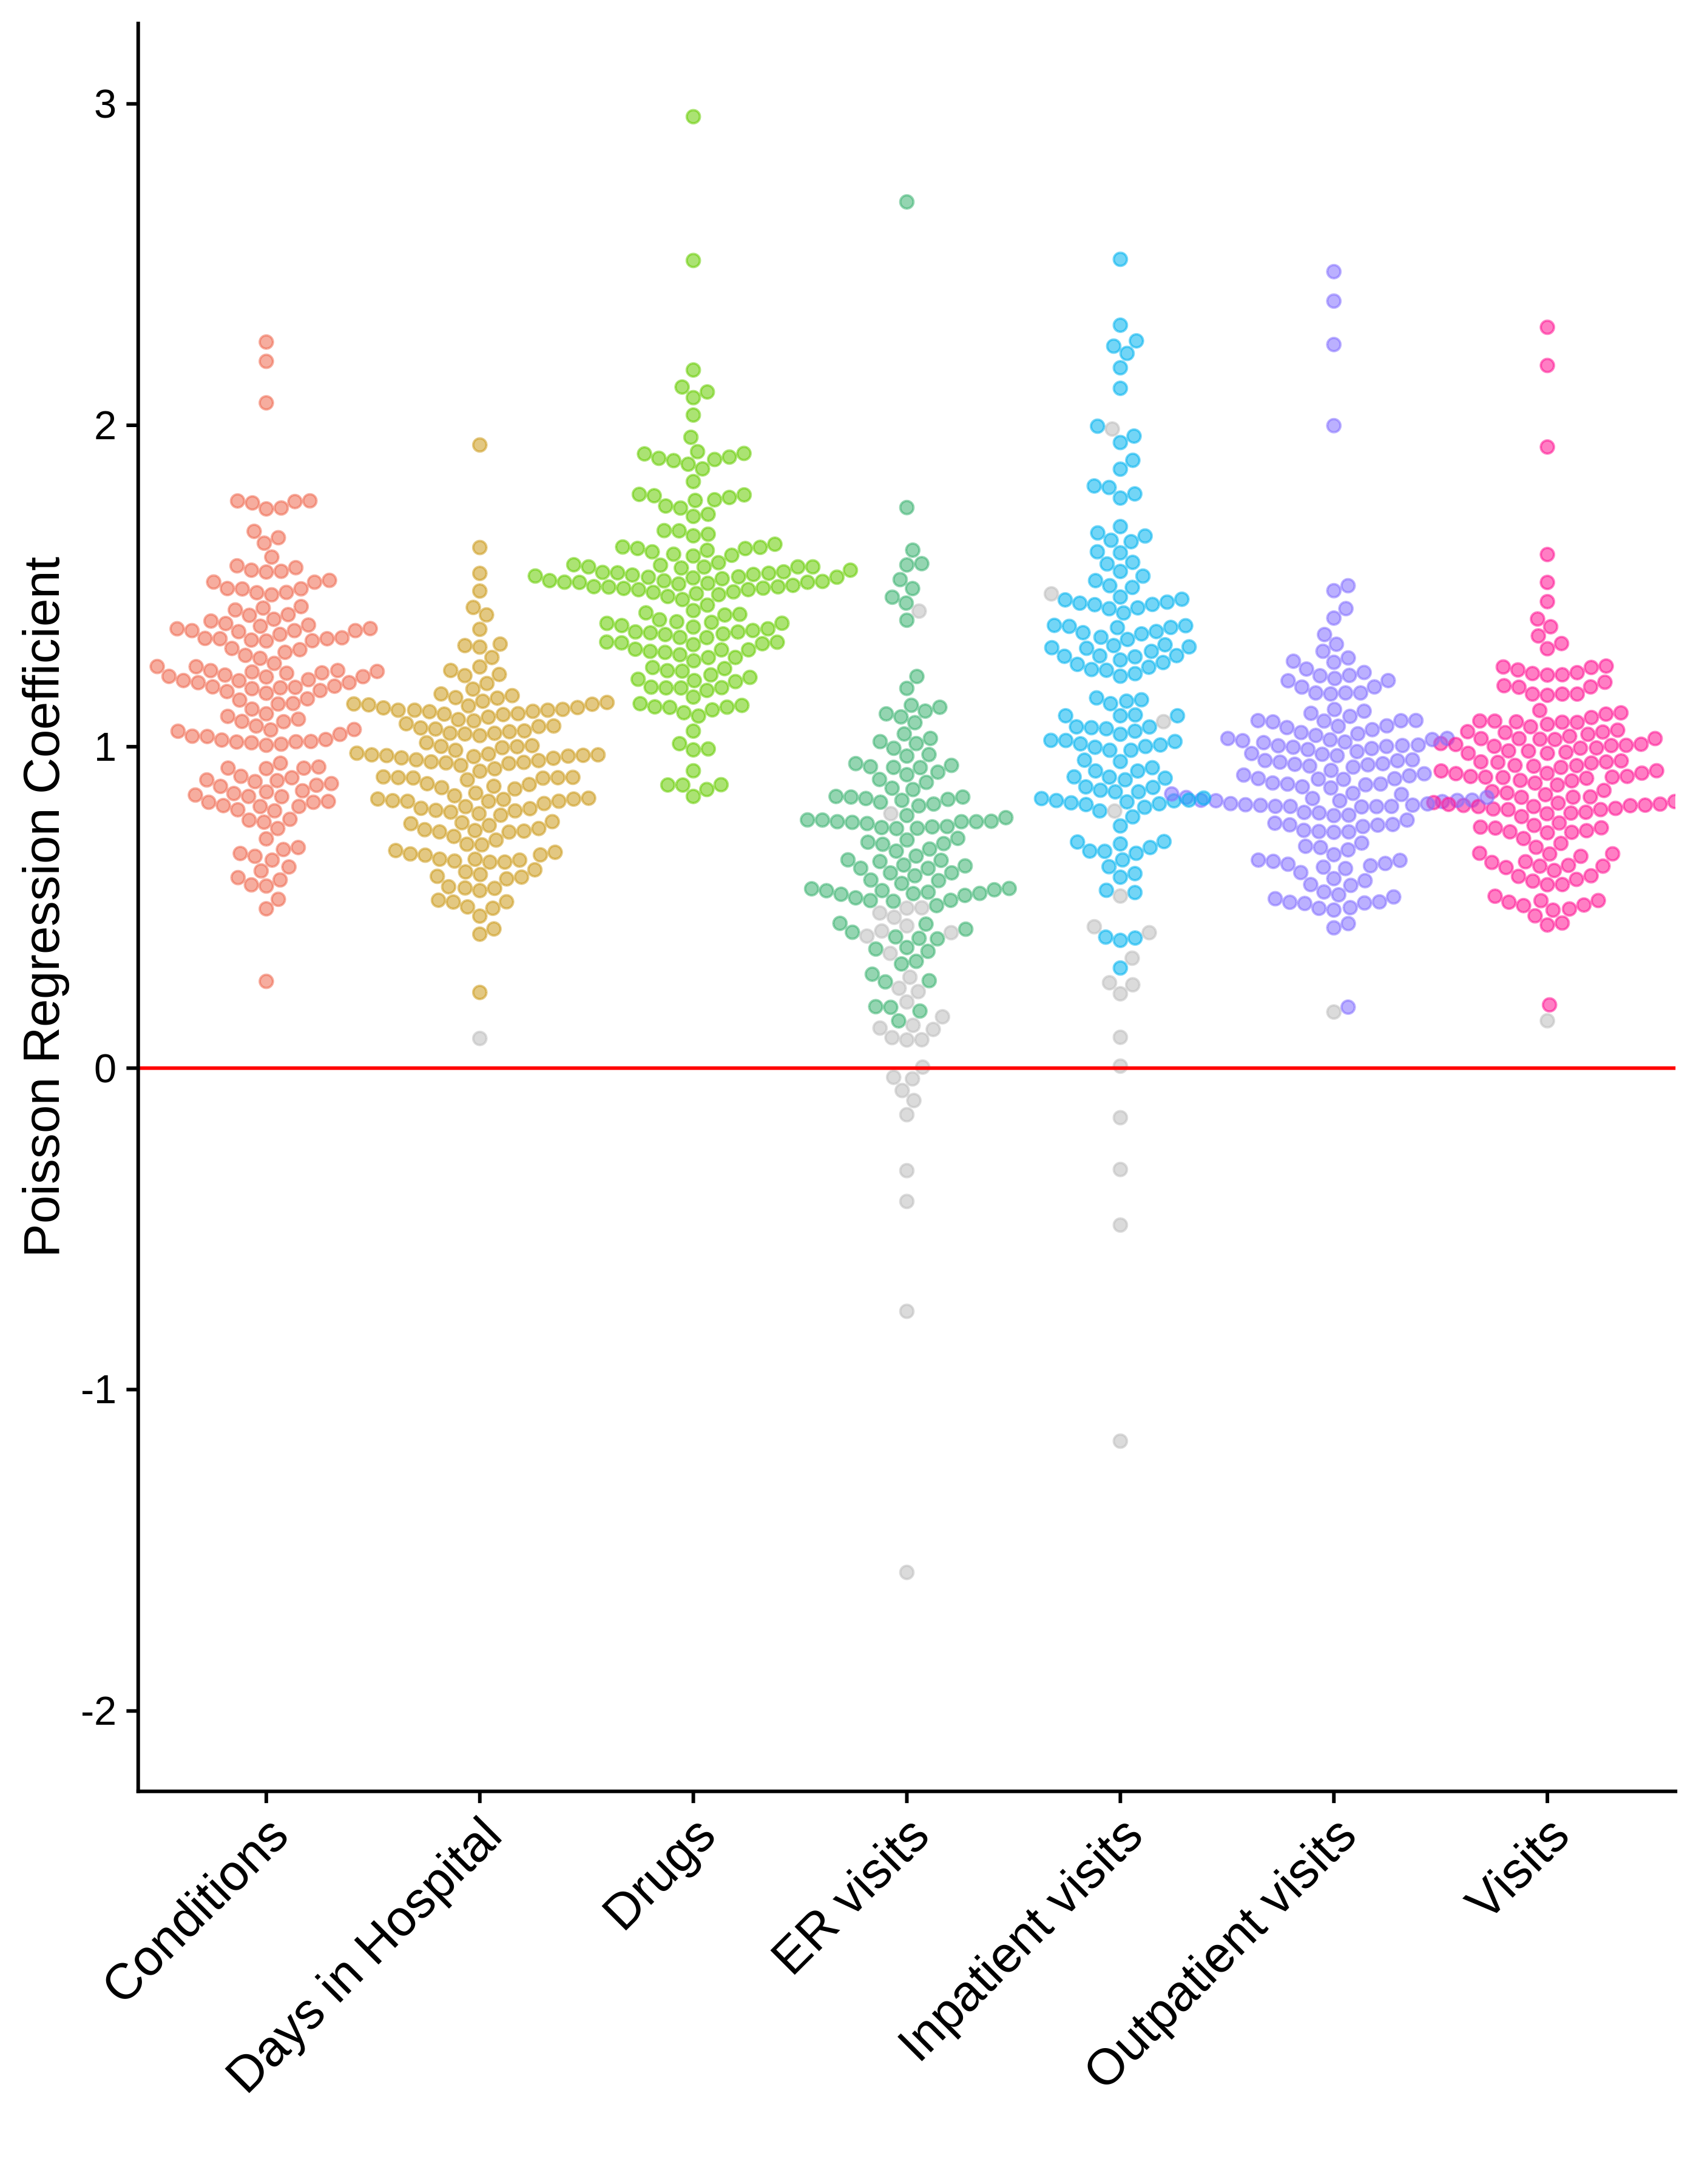

In [85]:
options(repr.plot.width = 7, repr.plot.height = 9, repr.plot.res = 400)
pois_gnm %>% filter(term == 'risk') %>%
    mutate(var_names = case_when(var == 'num_days_hosp' ~ 'Days in Hospital',
                                 var == 'num_conds' ~ 'Conditions',
                                 var == 'num_drugs' ~ 'Drugs',
                                 var == 'num_visits' ~ 'Visits',
                                 var == 'num_outpat' ~ 'Outpatient visits',
                                 var == 'num_ER' ~ 'ER visits',
                                 var == 'num_inpat' ~ 'Inpatient visits'),
          significant = factor(ifelse(p.value <=0.05, var, 'NS'))) %>%
ggplot(mapping = aes(x = var_names, y = estimate, color = significant, alpha = 0.5)) +
    geom_beeswarm(size = 1.5) +
    geom_hline(yintercept = 0, color = 'red') +
    theme_cowplot() +
    theme(legend.position = 'none',
          text = element_text(size = 15),
          axis.text.x = element_text(size = 15, angle = 45, hjust = 1)) +
    xlab('') +
    ylab('Poisson Regression Coefficient') +
    scale_color_manual(values = c('gray',
                                  'coral2',
                                  'goldenrod3',
                                  'chartreuse3', #greenyellow
                                  'lightslateblue', #mediumpurple2
                                  'deeppink',
                                  'mediumseagreen',
                                  'deepskyblue2'
                                 )) +
    ylim(c(-2,3))
ggsave("figure_1_poisson_res.png", bg = 'white',
       width = 7, height = 9, dpi=400, device = 'png')